### AeroSonicDB (YPAD-0523): Dataset Summary

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

In [2]:
if not os.path.exists('../figures'):
    os.mkdir('../figures')

In [3]:
dataset_path = '../data/raw'
df = pd.read_csv(os.path.join(dataset_path, 'sample_meta.csv'))

df['%dur'] = df['duration'] / df['duration'].sum()

In [4]:
def fetch_dataset_distribution(df, filter_by):
    # split dataset by training and test sets
    train = df[df['train-test'] == 'train'].reset_index(drop=False)
    test = df[df['train-test'] == 'test'].reset_index(drop=False)
    
    # cross tabulate train set by filter
    train_tab = pd.crosstab(index=train[filter_by].astype(str), 
                            columns=train['fold'], 
                            values=train['duration'], 
                            aggfunc='sum', 
                            margins=True, 
                            margins_name='TRAIN')
    
    train_tab.drop('TRAIN', inplace=True)
    
    for col in train_tab.columns:
        train_tab[col] = round(train_tab[col] / train_tab[col].sum() * 100, 2)
    
    # cross tabulate test set by filter
    test_tab = pd.crosstab(index=test[filter_by].astype(str), 
                             columns=test['fold'], 
                             values=test['duration'], 
                             aggfunc='sum')
    test_tab['test'] = round(test_tab['test'] / test_tab['test'].sum() * 100, 2)
    
    # bring in the environmental mappings
    env = pd.read_csv('../data/raw/environment_class_mappings.csv')

    zeros = 0
    ones = 0
        
    for col in env.columns:
        for i in env[col]:
            if i == '0':
                zeros += 1
            elif i == '1':
                ones += 1
            else:
                # skip the "ignore" statements
                pass

    total_env = zeros + ones
    
    if filter_by == 'class':

        env_df = pd.DataFrame(data={'ENV': [zeros, ones]}, index=['0', '1'])
        env_df['ENV'] = round((env_df['ENV'] / env_df['ENV'].sum()) * 100, 2)
        # bring the tables together
        train_tab['TEST'] = test_tab['test']
        train_tab['ENV'] = env_df['ENV']
        
    elif filter_by == 'location':
        
        # location "2" appears in the first 30 minutes of hour number 5 (index 4)
        env_loc_2 = env['4'][:360]
        
        zeros = 0
        ones = 0
        
        for i in env_loc_2:
            if i == '0':
                zeros += 1
            elif i == '1':
                ones += 1
            else:
                pass
        
        total_loc_2 = zeros + ones

        total_loc_0 = total_env - total_loc_2

        loc_0 = round(total_loc_0/total_env*100, 2)
        loc_2 = round(total_loc_2/total_env*100, 2)
            
        train_tab = train_tab.merge(test_tab, how='outer', left_index=True, right_index=True).fillna(0)
        train_tab['ENV'] = [loc_0, 0.00, loc_2]
        train_tab = train_tab.rename(columns={'test': 'TEST'}).fillna(0)           

    elif filter_by == 'mic':
        # only microphone "1" was used during environmental recording sessions
        train_tab = train_tab.merge(test_tab, how='outer', left_index=True, right_index=True).fillna(0)
        train_tab['ENV'] = [0.00, 100.00]
        train_tab = train_tab.rename(columns={'test': 'TEST'}).fillna(0)
    
    return train_tab
    

### Class Distribution

In [5]:
class_dist = fetch_dataset_distribution(df=df, filter_by='class')
class_dist

fold,1,2,3,4,5,TRAIN,TEST,ENV
class,,,,,,,,
0,24.86,18.24,29.51,27.45,30.26,26.28,37.4,79.95
1,75.14,81.76,70.49,72.55,69.74,73.72,62.6,20.05


In [6]:
# print(class_dist.to_latex(bold_rows=True))

### Location Distribution

In [7]:
loc_dist = fetch_dataset_distribution(df=df, filter_by='location')
loc_dist

fold,1,2,3,4,5,TRAIN,TEST,ENV
location,,,,,,,,
0,100.0,100.0,94.82,100.0,95.62,97.98,92.65,90.87
1,0.0,0.0,5.18,0.0,0.00,1.06,0.00,0.00
2,0.0,0.0,0.00,0.0,4.38,0.96,7.35,9.13


In [8]:
# print(loc_dist.to_latex(bold_rows=True))

### Microphone Distribution

In [9]:
mic_dist = fetch_dataset_distribution(df=df, filter_by='mic')
mic_dist

fold,1,2,3,4,5,TRAIN,TEST,ENV
mic,,,,,,,,
0,100.0,0.0,0.0,0.0,0.0,19.48,0.0,0.0
1,0.0,100.0,100.0,100.0,100.0,80.52,100.0,100.0


In [10]:
# print(mic_dist.to_latex(bold_rows=True))

### Temporal Distribution

In [11]:
df['date_time'] = df['date'] + ' ' + (df['time'].replace('-', ':', regex=True))
df['date_time'] = pd.to_datetime(df['date_time'])
df['day'] = df['date_time'].dt.day_name()
df['hour'] = df['date_time'].dt.hour

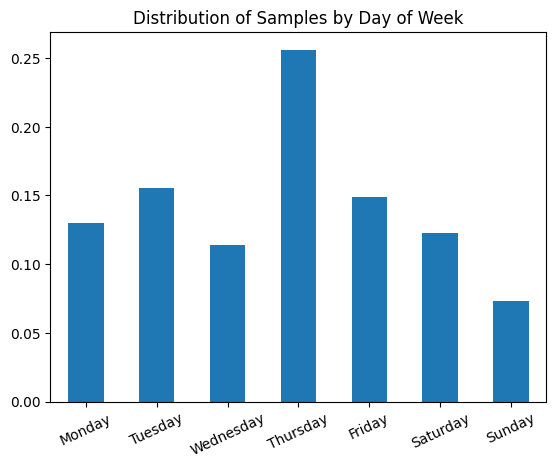

In [12]:
days = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday', 'Sunday']
df.groupby('day')[['%dur']].sum().reindex(days).plot(kind='bar')
plt.xticks(rotation=25)
plt.xlabel('')
plt.legend('', frameon=False)
plt.title('Distribution of Samples by Day of Week')
plt.savefig(f'../figures/day_of_week_dist.png', dpi=300)
plt.show()

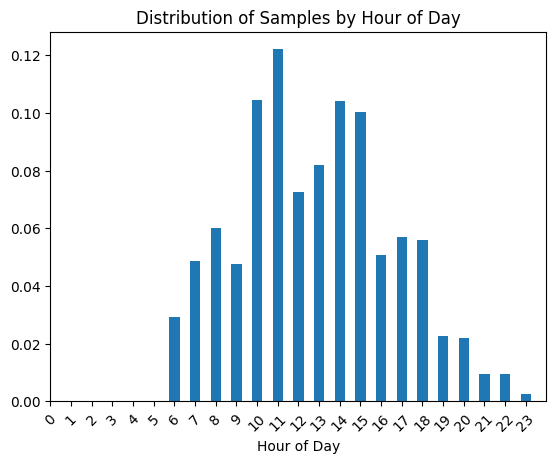

In [13]:
hours = range(0,24)
df.groupby('hour')[['%dur']].sum().reindex(hours).plot(kind='bar')
plt.xlim(left=0, right=24)
plt.xticks(rotation=45)
plt.xlabel('Hour of Day')
plt.legend('', frameon=False)
plt.title('Distribution of Samples by Hour of Day')
plt.savefig(f'../figures/hour_of_day_dist.png', dpi=300)
plt.show()

### Aircraft Features Summary

In [14]:
ac = df[df['class'] == 1]

In [15]:
ac.duration.describe()

count    625.000000
mean      51.104000
std        9.428734
min       18.000000
25%       47.000000
50%       53.000000
75%       60.000000
max       60.000000
Name: duration, dtype: float64

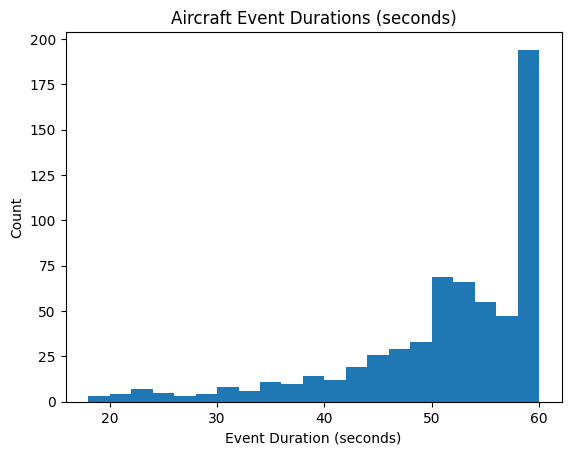

In [16]:
ac.duration.plot(kind='hist', bins=21)
plt.title('Aircraft Event Durations (seconds)')
plt.ylabel('Count')
plt.xlabel('Event Duration (seconds)')
plt.savefig(f'../figures/aircraft_event_durations.png', dpi=300)
plt.show()

In [17]:
ac['altitude'].describe()

count     625.000000
mean     3155.320000
std       714.395742
min      -225.000000
25%      2975.000000
50%      3250.000000
75%      3425.000000
max      5675.000000
Name: altitude, dtype: float64

In [18]:
ac.groupby('location')[['altitude']].agg(['min', 'max', 'median', 'mean'])

altitude                           
              min   max  median         mean
location                                    
0            1875  5675  3275.0  3277.166667
1            -100  1100   100.0   266.666667
2            -225   800   237.5   210.937500

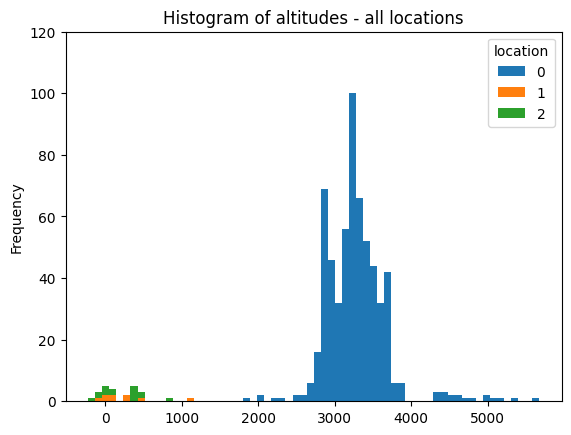

In [19]:
ac.pivot(columns='location').altitude.plot(kind = 'hist', stacked=True, bins=64)
plt.title('Histogram of altitudes - all locations')
plt.ylim(0,120)
plt.show()

In [20]:
ac['mtow'].describe()

count       625.000000
mean      62044.881600
std       56014.731948
min        1134.000000
25%       29574.000000
50%       73500.000000
75%       79015.000000
max      351800.000000
Name: mtow, dtype: float64

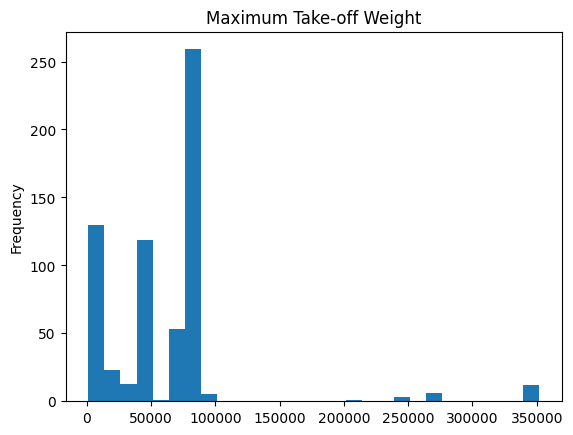

In [21]:
ac.mtow.plot(kind = 'hist', stacked=True, bins=28)
plt.title('Maximum Take-off Weight')
plt.show()

### n Most Frequent Values per Aircraft Feature

In [22]:
for col in ac.columns:
    if col in ['train-test', 'fold', 'filename', 'date', 'time', 'location', 
               'mic', 'class', 'subclass', 'session', 'offset', 'duration', 
               '%dur', 'file_length', 'reg', 'date_time', 'day', 'hour']:
        pass
    else:
        print(f'Column: {col}', '\n')
        print(pd.DataFrame(ac[col].value_counts()[:10]), '\n')
        print(f'N Unique values: {ac[col].nunique()}')
        print('\n')

Column: altitude 

          count
altitude       
3275         43
3250         32
3300         32
2875         22
3100         21
3375         20
3350         19
2850         19
3075         18
3225         17 

N Unique values: 89


Column: hex_id 

        count
hex_id       
7C7777     10
7C68CE      9
7C2BEE      8
7C779A      8
7C6C52      7
7C68D4      6
7C7526      5
7C752F      5
7C68AE      5
7C68B4      5 

N Unique values: 301


Column: airframe 

                        count
airframe                     
Power Driven Aeroplane    620
Rotorcraft                  5 

N Unique values: 2


Column: engtype 

            count
engtype          
Turbofan      470
Turboprop     114
Piston         37
Turboshaft      4 

N Unique values: 4


Column: engnum 

        count
engnum       
2         583
1          39
4           3 

N Unique values: 3


Column: shortdesc 

           count
shortdesc       
L2J          467
L2T           86
L1T           28
L2P           26
L1P         

### Silence Summary

In [23]:
sil = df[df['class'] == 0]

In [24]:
sil.duration.describe()

count    1270.000000
mean        9.971654
std         0.175262
min         8.000000
25%        10.000000
50%        10.000000
75%        10.000000
max        10.000000
Name: duration, dtype: float64

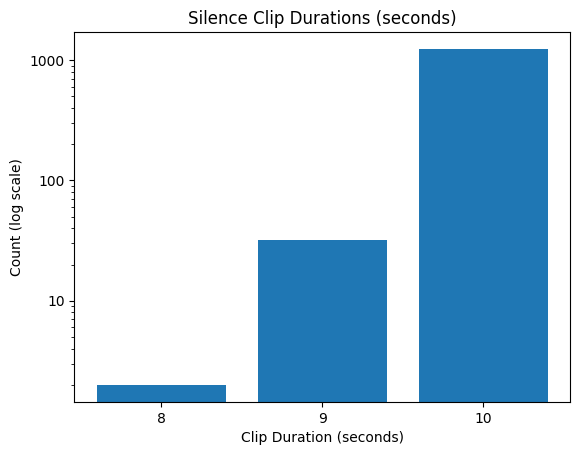

In [25]:
c = pd.DataFrame(sil.duration.value_counts()).reset_index().sort_values(by='duration').reset_index(drop=True)

fig, ax = plt.subplots()
plt.title('Silence Clip Durations (seconds)')

plt.bar(c['duration'], c['count'])
ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
plt.xlabel('Clip Duration (seconds)')

plt.yscale('log')
plt.ylabel('Count (log scale)')
ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
plt.savefig(f'../figures/silence_clip_durations.png', dpi=300)
plt.show()